## Setup

In the cell below we load the data in, transform it from pictures to tensors and normalize before using it to train our model.

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import random_split
from torchvision import datasets,transforms

DEVICE = torch.device("cpu")
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], 
                                         [0.229, 0.224, 0.225])])
train_dataset = torchvision.datasets.ImageFolder('./input/train',transform=transform)
test_dataset  = torchvision.datasets.ImageFolder('./input/valid',transform=transform)

# Get the number of features
input_shape=len(train_dataset)
train_data, val_data = random_split(train_dataset, [input_shape-int(input_shape*0.2), int(input_shape*0.2)])

y_train = np.array([y for x, y in iter(train_dataset)])
y_test = np.array([y for x, y in iter(test_dataset)])

## Creating the model

We create a `module` class that contains the details of our Convolution Neural Network model. Before having the data pass through the layers where the learning happens, we load a pre-trained model called `resnet18`. This is the convolutional part which determines which features to extract from the images in the dataset.

Then, we define the classifier wrapper using `Skorch` and finally train the model. Currently, we are working on exploring which layers are best to include and which activation functions to use on them. Experimentation is being done in picking the best Loss Function for this binomial classification. In the future, a section for hyper-parameter tuning will be added as well.

In [2]:
import torch.nn as nn
from torch.nn import functional as F
from torchvision import models

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        model = models.resnet18(pretrained=True)
        model.first_layer = nn.Linear(1000, 64)
        model.second_layer = nn.Linear(64, 1)
        self.model = model

    def forward(self, x):
        
        X = self.model(x)
        
        return torch.sigmoid(X)


In [3]:
from skorch import NeuralNetClassifier
from torch import optim

#torch.manual_seed(0)

net = NeuralNetClassifier(
    ConvNet,
    max_epochs=10,
    iterator_train__num_workers=2,
    iterator_valid__num_workers=2,
    lr=1e-3,
    batch_size=64,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    device=DEVICE
)

In [4]:
net.fit(train_dataset, y=y_train);

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        6.2139       0.5586        5.9945  219.6741
      2        5.9220       0.4404        5.9124  200.4969
      3        5.9116       0.5664        5.9133  205.5200
      4        5.9114       0.4814        5.9113  194.5069
      5        5.9113       0.5469        5.9113  213.5708
      6        5.9112       0.5527        5.9112  219.2262
      7        5.9112       0.5664        5.9112  197.7524
      8        5.9112       0.5596        5.9112  210.9500
      9        5.9112       0.5596        5.9113  217.0688
     10        5.9112       0.5635        5.9113  207.2809


## Visualizing training steps

Below we give some visuals of the training process.

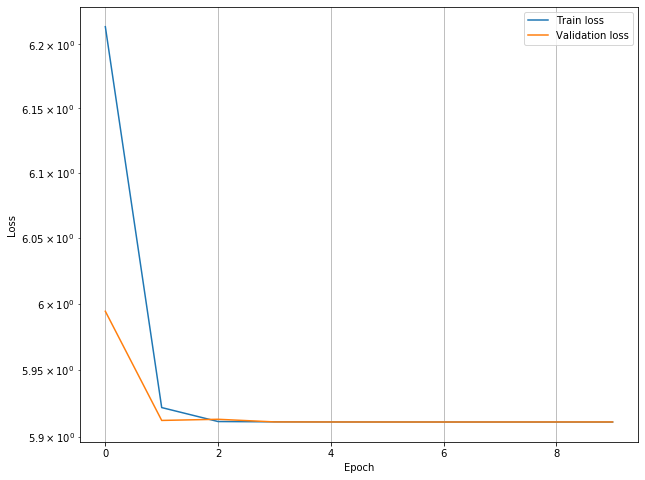

In [5]:
import matplotlib.pyplot as plt

val_loss=[]
train_loss=[]
for i in range(10):
    val_loss.append(net.history[i]['valid_loss'])
    train_loss.append(net.history[i]['train_loss'])
    
plt.figure(figsize=(10,8))
plt.semilogy(train_loss, label='Train loss')
plt.semilogy(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show() 